In [74]:
import os 
import pandas as pd
import numpy as np
from pybalmorel import IncFile

path = r'C:\Users\mathi\gitRepos\balmorel-preprocessing\Raw Data Processing\Data\PyPSA-Eur-Sec Data\emobility'

os.listdir(path)


['Bus__count',
 'European_countries_car_ownership.csv',
 'KFZ__count',
 'Lfw__count',
 'Lkw__count',
 'LoA__count',
 'Lzg__count',
 'Pkw__count',
 'PmA__count',
 'Sat__count',
 'traffic.tex']

<Axes: >

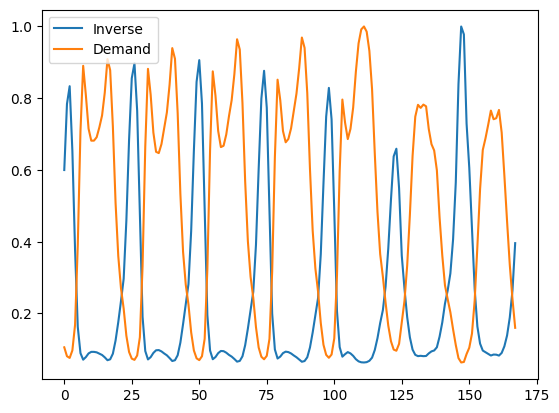

In [127]:
# KFZ lader til at være alle køretøjer, og den som PyPSA bruger 

all_profiles = pd.DataFrame()
for file in os.listdir(path):
    if '__count' in file:
        f = pd.read_csv(os.path.join(path, file), skiprows=2)
        f = f.pivot_table(index=['day', 'hour'],
                            values='count')
        f = f / np.max(f)
        
        if len(all_profiles) == 0:
            all_profiles = pd.concat((all_profiles, f.reset_index()))
            all_profiles.columns = ['day', 'hour', file]
        else:
            all_profiles[file] = f.loc[:, 'count'].values 
        # f.plot(title=file)
        
# all_profiles.pivot_table(index=['day', 'hour']).plot()
inv_demand = 1/all_profiles['KFZ__count'] 
inv_demand = inv_demand / np.max(inv_demand)
ax = inv_demand.plot(label='Inverse', legend=True)
(all_profiles['KFZ__count']).plot(ax=ax, label='Demand', legend=True)

In [136]:
FLEXDEM_MAXCONS = IncFile(name='FLEXDEM_MAXLIMIT',
                          path='base/data',
                          suffix="\n;\nFLEXMAXLIMIT(FLEXUSER, RRR, SSS, TTT) = FLEXMAXLIMIT1('S01',TTT,FLEXUSER);\nFLEXMAXLIMIT1(SSS,TTT,FLEXUSER)=0;")


FLEXDEM_MAXCONS.prefix = """* Normalised, inverse of mobility demand as a maximum charging constraint on flexible EV demand
* Data from KFZ mobility demand in Brown, T., D. Schlachtberger, A. Kies, S. Schramm, and M. Greiner. ‘Synergies of Sector Coupling and Transmission Reinforcement in a Cost-Optimised, Highly Renewable European Energy System’. Energy 160 (October 2018): 720–39. https://doi.org/10.1016/j.energy.2018.06.222.
TABLE FLEXMAXLIMIT1(SSS, TTT, FLEXUSER) 'Maximum flexible consumption wrt. season and term (%)'                          
"""

# Make correct index
ind = pd.MultiIndex.from_product((['S01'], ['T00%d'%i for i in range(1, 10)] + ['T0%d'%i for i in range(10, 100)] + ['T%d'%i for i in range(100, 169)]))
ind.names = ['S', 'T']
body = pd.DataFrame(data=inv_demand.values, index=ind, columns=['ELECTRIC_VEHICLES']).reset_index()

# Insert to incfile and prepare
FLEXDEM_MAXCONS.body = body
FLEXDEM_MAXCONS.body_prepare(index=['S', 'T'],
                             columns=None,
                             values='ELECTRIC_VEHICLES')
FLEXDEM_MAXCONS.save()
